In [1]:
import time
# science
import numpy as np
import torch
from einops import repeat, rearrange

In [2]:
import joblib
import sidechainnet

In [3]:
from sidechainnet.utils.sequence import ProteinVocabulary as VOCAB
VOCAB = VOCAB()

### Load a protein in SCN format - you can skip this since a joblib file is provided

In [4]:
dataloaders = sidechainnet.load(casp_version=7, with_pytorch="dataloaders")
dataloaders.keys() # ['train', 'train_eval', 'valid-10', ..., 'valid-90', 'test']
# ProteinDataset(casp_version=12, split='train', n_proteins=81454,
#               created='Sep 20, 2020')

SidechainNet was loaded from ./sidechainnet_data/sidechainnet_casp7_30.pkl.


dict_keys(['train', 'train-eval', 'test', 'valid-10', 'valid-20', 'valid-30', 'valid-40', 'valid-50', 'valid-70', 'valid-90'])

In [5]:
min_len = 100
for batch in dataloaders['train']:
    real_seqs = [''.join([VOCAB.int2char(aa) for aa in seq]) for seq in batch.int_seqs.numpy()]
    print("seq len", len(real_seqs[0]))
    try:
        for i in range(len(batch.int_seqs.numpy())):
            # get variables
            seq     = real_seqs[i]
            int_seq = batch.int_seqs[i]
            angles  = batch.angs[i]
            # get padding
            padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
            padding_seq    = (np.array([x for x in seq]) == "_").sum()
            # only accept sequences with right dimensions and no missing coords
            # if padding_seq == padding_angles:
            # print("paddings_match")
            # print("len coords", list(batch.crds[i].shape)[0]//3, "vs int_seq", len(int_seq))
            if list(batch.crds[i].shape)[0]//14 == len(int_seq):
                if len(seq) > min_len and padding_seq == padding_angles:
                    print("stopping at sequence of length", len(seq))
                    print(len(seq), angles.shape, padding_seq == padding_angles == list(batch.crds[i].shape)[0]//3)
                    print("paddings: ", padding_seq, padding_angles)
                    raise StopIteration
                else:
                    print("found a seq of length:", len(seq), "but below the threshold:", min_len)
    except StopIteration:
        break

seq len 219
found a seq of length: 219 but below the threshold: 100
found a seq of length: 219 but below the threshold: 100
stopping at sequence of length 219
219 torch.Size([219, 12]) tensor(False)
paddings:  9 tensor(9)


### Load joblib file

In [6]:
# joblib.dump({"seq": seq, "int_seq": int_seq, "angles": angles,
#              "id": batch.pids[i], "true_coords": batch.crds[i]}, "experiments/112_aas_seq_and_angles.joblib")
info = joblib.load("experiments/344_aas_seq_and_angles.joblib")
seq, int_seq, angles, id_, true_coords = info["seq"], info["int_seq"], info["angles"], info["id"], info["true_coords"]

padding_angles = (torch.abs(angles).sum(dim=-1) == 0).long().sum()
padding_seq    = (np.array([x for x in seq]) == "_").sum()

### Load algo

In [7]:
from massive_pnerf import *

In [8]:
# measure time to featurize
# %timeit build_scaffolds(seq[:-padding_seq], angles[:-padding_seq])

In [10]:
# featurize
scaffolds = build_scaffolds_from_scn_angles(seq[:-padding_seq], angles[:-padding_seq])
# modify scaffolds with true data
scaffolds_ = modify_scaffolds_with_coords(scaffolds, 
                                          rearrange(true_coords, '(l c) d -> l c d', c=14)[:-padding_seq])

In [11]:
scaffolds["bond_mask"].shape, scaffolds_["bond_mask"].shape

(torch.Size([331, 14]), torch.Size([331, 14]))

In [20]:
# %%timeit
n_iters = 15000
errors, errors_3d  = [], []
coords_wrapper = true_coords[:]
# do n times and check error
for i in range(n_iters):
    # modify scaffolds with true data
    scaffolds_ = modify_scaffolds_with_coords(scaffolds, 
                                              rearrange(coords_wrapper, '(l c) d -> l c d', c=14)[:-padding_seq])
    # scaffolds_ = scaffolds
    # convert coords - fold
    coords, mask = proto_fold(seq[:-padding_seq], **scaffolds_)
    coords_flat  = rearrange(coords, 'l c d -> (l c) d') 
    
    # align
    flat_mask = rearrange(scaffolds_["cloud_mask"], 'l d -> (l d)')
    coords_aligned, labels_aligned = kabsch_torch(coords_flat[flat_mask].t(),
                                                  true_coords[:-14*padding_angles][flat_mask].t())
    # create coord scaffolds
    scaff_coords_aligned = torch.zeros(coords_flat.shape).float()
    scaff_labels_aligned = torch.zeros(coords_flat.shape).float()
    # fill
    scaff_coords_aligned[flat_mask] = coords_aligned.t()
    scaff_labels_aligned[flat_mask] = labels_aligned.t()
    # replace vars
    coords_aligned, labels_aligned = scaff_coords_aligned, scaff_labels_aligned
        
    # record evolution
    errors.append(rmsd_torch(coords_aligned, labels_aligned).item())
    errors_3d.append( (coords_aligned - labels_aligned).abs().mean(dim=-2) )
    if i % 50 == 0:
        print(i, "RMSD is:", errors[-1], "|| abs_error in 3 axis:", errors_3d[-1])
    
    # update coords
    coords_wrapper = torch.zeros_like( rearrange(true_coords, '(l c) d -> l c d', c=14) )
    coords_wrapper[:-padding_angles][scaffolds_["cloud_mask"]] = rearrange(coords_aligned, '(l c) d -> l c d', c=14)[scaffolds_["cloud_mask"]]
    coords_wrapper = rearrange(coords_wrapper, 'l c d -> (l c) d')
    

0 RMSD is: 0.15417370200157166 || abs_error in 3 axis: tensor([0.0560, 0.0505, 0.0508])
50 RMSD is: 0.3964884281158447 || abs_error in 3 axis: tensor([0.0889, 0.0644, 0.0852])
100 RMSD is: 0.4209273159503937 || abs_error in 3 axis: tensor([0.0729, 0.1112, 0.0785])
150 RMSD is: 0.406270831823349 || abs_error in 3 axis: tensor([0.0730, 0.0891, 0.0767])
200 RMSD is: 0.40864863991737366 || abs_error in 3 axis: tensor([0.1160, 0.0948, 0.0600])
250 RMSD is: 0.44030600786209106 || abs_error in 3 axis: tensor([0.0941, 0.0970, 0.0753])
300 RMSD is: 0.45274293422698975 || abs_error in 3 axis: tensor([0.0917, 0.0837, 0.0802])
350 RMSD is: 0.422430157661438 || abs_error in 3 axis: tensor([0.0868, 0.0859, 0.0779])
400 RMSD is: 0.447654128074646 || abs_error in 3 axis: tensor([0.0842, 0.0918, 0.0870])
450 RMSD is: 0.35498979687690735 || abs_error in 3 axis: tensor([0.0691, 0.0833, 0.0717])
500 RMSD is: 0.37560588121414185 || abs_error in 3 axis: tensor([0.0703, 0.0724, 0.0913])
550 RMSD is: 0.349479

4550 RMSD is: 0.39772626757621765 || abs_error in 3 axis: tensor([0.1607, 0.0863, 0.2130])
4600 RMSD is: 0.4647863805294037 || abs_error in 3 axis: tensor([0.1740, 0.0974, 0.2300])
4650 RMSD is: 0.43309178948402405 || abs_error in 3 axis: tensor([0.1788, 0.1047, 0.2065])
4700 RMSD is: 0.46063458919525146 || abs_error in 3 axis: tensor([0.1739, 0.1060, 0.2195])
4750 RMSD is: 0.5327308177947998 || abs_error in 3 axis: tensor([0.1999, 0.1109, 0.2288])
4800 RMSD is: 0.4800189733505249 || abs_error in 3 axis: tensor([0.1753, 0.1062, 0.2278])
4850 RMSD is: 0.4666789174079895 || abs_error in 3 axis: tensor([0.1780, 0.0968, 0.2332])
4900 RMSD is: 0.47721120715141296 || abs_error in 3 axis: tensor([0.1894, 0.1143, 0.2300])
4950 RMSD is: 0.431517630815506 || abs_error in 3 axis: tensor([0.1738, 0.0952, 0.2374])
5000 RMSD is: 0.504112184047699 || abs_error in 3 axis: tensor([0.1849, 0.1107, 0.2456])
5050 RMSD is: 0.4198639988899231 || abs_error in 3 axis: tensor([0.1779, 0.1186, 0.2245])
5100 RMS

9150 RMSD is: 0.5846536755561829 || abs_error in 3 axis: tensor([0.2747, 0.1885, 0.3870])
9200 RMSD is: 0.5746551156044006 || abs_error in 3 axis: tensor([0.2763, 0.1611, 0.4001])
9250 RMSD is: 0.5816131234169006 || abs_error in 3 axis: tensor([0.2744, 0.1679, 0.3940])
9300 RMSD is: 0.5797552466392517 || abs_error in 3 axis: tensor([0.2783, 0.1751, 0.3906])
9350 RMSD is: 0.6098363995552063 || abs_error in 3 axis: tensor([0.2838, 0.1818, 0.3996])
9400 RMSD is: 0.6096433401107788 || abs_error in 3 axis: tensor([0.2969, 0.1831, 0.3963])
9450 RMSD is: 0.6148340702056885 || abs_error in 3 axis: tensor([0.2827, 0.1790, 0.4117])
9500 RMSD is: 0.6044936776161194 || abs_error in 3 axis: tensor([0.2854, 0.1783, 0.4025])
9550 RMSD is: 0.6503690481185913 || abs_error in 3 axis: tensor([0.2920, 0.1945, 0.4191])
9600 RMSD is: 0.6026778221130371 || abs_error in 3 axis: tensor([0.2942, 0.1867, 0.4048])
9650 RMSD is: 0.6157572865486145 || abs_error in 3 axis: tensor([0.2931, 0.1922, 0.4089])
9700 RMSD 

13700 RMSD is: 0.8255413174629211 || abs_error in 3 axis: tensor([0.4018, 0.2663, 0.5807])
13750 RMSD is: 0.8149794340133667 || abs_error in 3 axis: tensor([0.4196, 0.2641, 0.5632])
13800 RMSD is: 0.800688624382019 || abs_error in 3 axis: tensor([0.4178, 0.2588, 0.5618])
13850 RMSD is: 0.8030731678009033 || abs_error in 3 axis: tensor([0.4070, 0.2555, 0.5719])
13900 RMSD is: 0.8072218894958496 || abs_error in 3 axis: tensor([0.4073, 0.2583, 0.5820])
13950 RMSD is: 0.8013431429862976 || abs_error in 3 axis: tensor([0.4108, 0.2614, 0.5785])
14000 RMSD is: 0.7763640880584717 || abs_error in 3 axis: tensor([0.4166, 0.2446, 0.5701])
14050 RMSD is: 0.7610790729522705 || abs_error in 3 axis: tensor([0.4151, 0.2640, 0.5569])
14100 RMSD is: 0.755922794342041 || abs_error in 3 axis: tensor([0.4055, 0.2554, 0.5582])
14150 RMSD is: 0.8178287744522095 || abs_error in 3 axis: tensor([0.4203, 0.2655, 0.5879])
14200 RMSD is: 0.8031629323959351 || abs_error in 3 axis: tensor([0.4164, 0.2563, 0.5825])
1

### Make cool plot

In [21]:
import matplotlib.pyplot as plt

In [22]:
joblib.dump({"rmsd": errors, "axis_abs": torch.stack(errors_3d, dim=0)}, "experiments/looping_error.joblib")
data = joblib.load("experiments/looping_error.joblib")

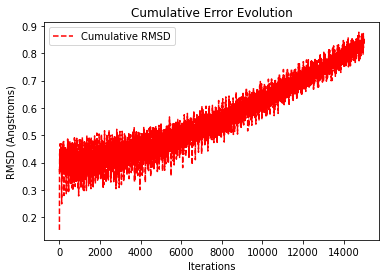

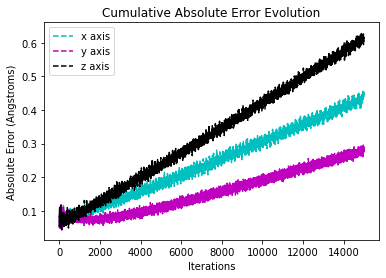

In [23]:
# RMSD
plt.title("Cumulative Error Evolution")
plt.plot(errors, 'r--', label="Cumulative RMSD")
plt.ylabel("RMSD (Angstroms)")
plt.xlabel("Iterations")
plt.legend()
plt.show()

# 3d axis ABS ERROR
plt.title("Cumulative Absolute Error Evolution")
plt.plot(data["axis_abs"][:, 0].numpy(), 'c--', label="x axis")
plt.plot(data["axis_abs"][:, 1].numpy(), 'm--', label="y axis")
plt.plot(data["axis_abs"][:, 2].numpy(), 'k--', label="z axis")
plt.ylabel("Absolute Error (Angstroms)")
plt.xlabel("Iterations")
plt.legend()
plt.show()